# Digital Image Processing(810055-31001)<br>[final term] business card recognition (2/2)  
### 3팀 인공지능응용학과 강준(23102308), 김나현(22102304)

In [1]:
# Import Library
import os
import itertools

import cv2
import numpy as np
import matplotlib.pyplot as plt

import random
from scipy.ndimage import maximum_filter

In [2]:
# If you use Google Colab and Google Drive, use this.

# from google.colab.patches import cv_imshow
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Image Directory
# base_dir = '/content/drive/MyDrive/DIP/FINALTERM' # For Colab
base_dir = 'businesscard' # For Local
img_list = []
for i in range(1, 22):
    fname = f"BC{i}.jpg"
    path = os.path.join(base_dir, fname)
    img = cv2.imread(path)
    if img is None:
        print(f"{fname} load error")
    else:
        img_list.append(img)

print(f"Total number of images loaded: {len(img_list)}")

Total number of images loaded: 21


#### 강준(23102308)

In [4]:
# Result Directory: Kang (Plot, Businesscard Image)
output_plot_kang = "output_kang"
output_crop_kang = "output_kang/result"

os.makedirs(output_plot_kang, exist_ok=True)
os.makedirs(output_crop_kang, exist_ok=True)

In [ ]:
# Line Detection (Hough Transform with Non-Maximum Suppression)
# Source: https://github.com/opencv/opencv/blob/4.x/modules/imgproc/src/hough.cpp#L923
def hough_transform_lines_nms(img, rho_res=1, theta_res=np.pi/180, threshold=100, nms_size=3):
    # 가능한 최대 rho 값 (대각선 길이), rho 값 범위 (-D ~ D), theta 값 범위 (0 ~ 180도)
    height, width = img.shape
    diag_len = int(np.ceil(np.sqrt(height ** 2 + width ** 2)))
    rhos = np.arange(-diag_len, diag_len + 1, rho_res)
    thetas = np.arange(0, np.pi, theta_res)

    # Accumulator 생성: (rho 개수, theta 개수) 형태의 2D 배열
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    y_idxs, x_idxs = np.nonzero(img)filterBilateral 

    cos_t = np.cos(thetas)
    sin_t = np.sin(thetas)

    # 각 Edge 픽셀에 대해 모든 theta에 대한 rho 값을 계산하여 accumulator에 count
    for i in range(len(x_idxs)):
        x = x_idxs[i]
        y = y_idxs[i]
        for t_idx in range(len(thetas)):
            rho = int(round(x * cos_t[t_idx] + y * sin_t[t_idx])) + diag_len
            accumulator[rho, t_idx] += 1
    
    # Non-Maximum Suppression (주변보다 큰 값만 남기기 위함)
    nms_accum = maximum_filter(accumulator, size=nms_size)

    mask = (accumulator == nms_accum) & (accumulator >= threshold)
    lines = []
    for r_idx, t_idx in zip(*np.nonzero(mask)):
        rho = rhos[r_idx]
        theta = thetas[t_idx]
        lines.append([[float(rho), float(theta)]])

    return np.array(lines, dtype=np.float32)


# 유사한 각도를 가지고, 비슷한 위치에 있는 중복되는 선 제거
def filter_similar_lines_by_angle_rho(lines, angle_thresh=5, rho_thresh=170):
    filtered = []
    # Each Line (rho, theta)에 대해 유사한 기존 Line이 있으면 제외
    for (rho, theta) in lines[:, 0]:
        angle_deg = np.rad2deg(theta)
        is_duplicate = False
        for (r, t) in filtered:
            # theta 차이가 angle_thresh 미만 (기울기 유사), rho 차이가 rho_thresh 미만 (위치 유사)
            if abs(np.rad2deg(t) - angle_deg) < angle_thresh and abs(r - rho) < rho_thresh:
                is_duplicate = True
                break
        if not is_duplicate:
            filtered.append((rho, theta))
            
    return np.array(filtered)


# Two Lines, Compute Intersection Points
def compute_intersection_from_points(p1, p2, q1, q2):
    A1, B1 = p2[1] - p1[1], p1[0] - p2[0]
    C1 = A1 * p1[0] + B1 * p1[1]
    A2, B2 = q2[1] - q1[1], q1[0] - q2[0]
    C2 = A2 * q1[0] + B2 * q1[1]
    det = A1 * B2 - A2 * B1
    if abs(det) < 1e-10:
        return None
    x = (B2 * C1 - B1 * C2) / det
    y = (A1 * C2 - A2 * C1) / det

    return np.array([x, y], dtype=np.float32)


# Point를 시계방향 정렬
def order_points_clock(pts):
    center = np.mean(pts, axis=0)
    def angle(p):
        return np.arctan2(p[1] - center[1], p[0] - center[0])
    
    return sorted(pts, key=angle)


# 유효한 사각형 검증
def is_valid_quad(pts, min_area=3000):
    pts = np.array(pts, dtype=np.int32)
    if not cv2.isContourConvex(pts):
        return False
    area = cv2.contourArea(pts)

    return area > min_area


# Random Sample Consensus를 이용해 여러 사각형 후보 생성
def find_quadrilateral_candidates_ransac(points, min_area=3000, max_trials=200):
    quads = []
    points = list(points)
    if len(points) < 4:
        return quads
    for _ in range(max_trials):
        combo = random.sample(points, 4)
        ordered = order_points_clock(combo)
        if is_valid_quad(ordered, min_area):
            quads.append(np.array(ordered, dtype=np.int32))

    return quads


# Three Points, Compute Angle
def angle_between(p1, p2, p3):
    v1 = np.array(p1) - np.array(p2)
    v2 = np.array(p3) - np.array(p2)
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    angle = np.arccos(np.clip(cos_angle, -1.0, 1.0))

    return np.degrees(angle)


# 직사각형 유사성 점수
def score_quad_rectangularity(quad):
    quad = list(quad)
    angles = [angle_between(quad[i-1], quad[i], quad[(i+1)%4]) for i in range(4)]

    return np.sum((np.array(angles) - 90)**2)


# 이미지 중심성 점수
def score_quad_centered(quad, image_shape):
    img_center = np.array([image_shape[1] / 2, image_shape[0] / 2])
    quad_center = np.mean(quad, axis=0)

    return np.linalg.norm(img_center - quad_center)


# 사각형 종횡비 점수
def aspect_ratio_score(quad):
    quad = order_points_clock(quad)
    width = (np.linalg.norm(quad[0] - quad[1]) + np.linalg.norm(quad[2] - quad[3])) / 2
    height = (np.linalg.norm(quad[0] - quad[3]) + np.linalg.norm(quad[1] - quad[2])) / 2

    return width / (height + 1e-5)


# Weighted Sum
# 면적 점수, 직사각형 점수, 중심성 점수, 종횡비 점수를 가중치를 부여해 최종 점수 계산
# best 사각형 선택
def select_best_quad_combined(quads, image_shape, weights=(0.2, 0.45, 0.2, 0.15)):
    if not quads:
        return None
    areas = np.array([cv2.contourArea(q) for q in quads])
    rectangularities = np.array([score_quad_rectangularity(q) for q in quads])
    centers = np.array([score_quad_centered(q, image_shape) for q in quads])
    aspect_ratios = np.array([aspect_ratio_score(q) for q in quads])
    area_scores = areas / (areas.max() + 1e-5)
    rectangularity_scores = 1 - rectangularities / (rectangularities.max() + 1e-5)
    center_scores = 1 - centers / (centers.max() + 1e-5)
    ideal_aspect = 1.7
    aspect_scores = 1 - np.abs(aspect_ratios - ideal_aspect) / ideal_aspect
    aspect_scores = np.clip(aspect_scores, 0, 1)
    a, r, c, s = weights
    final_scores = a*area_scores + r*rectangularity_scores + c*center_scores + s*aspect_scores
    best_idx = np.argmax(final_scores)

    return quads[best_idx]


# 최종 선택된 사각형을 명함 비율에 맞게 Perspective Warping
def warp_perspective_auto_size(image, quad, base_width=800):
    quad = np.array(order_points_clock(quad), dtype=np.float32)
    width_top = np.linalg.norm(quad[0] - quad[1])
    width_bottom = np.linalg.norm(quad[2] - quad[3])
    width = (width_top + width_bottom) / 2
    height_left = np.linalg.norm(quad[0] - quad[3])
    height_right = np.linalg.norm(quad[1] - quad[2])
    height = (height_left + height_right) / 2

    if width >= height:
        out_width, out_height = 900, 530
    else:
        out_width, out_height = 530, 900

    dst_pts = np.array([
        [0, 0],
        [out_width - 1, 0],
        [out_width - 1, out_height - 1],
        [0, out_height - 1]
    ], dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(quad, dst_pts)
    warped = cv2.warpPerspective(image, matrix, (out_width, out_height))

    return warped

In [6]:
# BC1 ~ BC21
for i, image in enumerate(img_list):
    filename = f"BC{i+1}"

    # Preprocessing
    base_width = 800
    height = int(image.shape[0] * base_width / image.shape[1])
    resized = cv2.resize(image, (base_width, height))
    gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    
    median = cv2.medianBlur(gray, 5)
    blurred = cv2.GaussianBlur(median, (9, 9), 0)
    edges = cv2.Canny(blurred, 60, 180)

    # Delete Corner
    gray_float = np.float32(median)
    dst = cv2.cornerHarris(gray_float, 2, 3, 0.04)
    dst_dilated = cv2.dilate(dst, None)
    corner_coords = np.argwhere(dst_dilated > 0.01 * dst_dilated.max())

    edges_removed = edges.copy()
    corner_mask = np.zeros_like(edges, dtype=np.uint8)
    for y, x in corner_coords:
        y1, y2 = max(0, y-1), min(edges.shape[0], y+2)
        x1, x2 = max(0, x-1), min(edges.shape[1], x+2)
        edges_removed[y1:y2, x1:x2] = 0
        corner_mask[y1:y2, x1:x2] = 255

    non_corner_mask = cv2.bitwise_not(corner_mask)
    edges_dilatable = cv2.bitwise_and(edges_removed, edges_removed, mask=non_corner_mask)
    edges_dilated = cv2.dilate(edges_dilatable, np.ones((3, 3), np.uint8), iterations=1)
    final_edges = cv2.bitwise_or(edges_dilated, cv2.bitwise_and(edges_removed, corner_mask))

    # Line Detection
    lines_std = cv2.HoughLines(final_edges, 1, np.pi / 180, threshold=150)
    # lines_std = hough_transform_lines_nms(final_edges, 1, np.pi / 180, threshold=150)
    lines_filtered = filter_similar_lines_by_angle_rho(lines_std) if lines_std is not None else []

    vis_all_lines = cv2.cvtColor(final_edges, cv2.COLOR_GRAY2BGR)
    if lines_std is not None:
        for rho, theta in lines_std[:, 0]:
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
            pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
            cv2.line(vis_all_lines, pt1, pt2, (255, 0, 0), 1)

    vis_lines = cv2.cvtColor(final_edges, cv2.COLOR_GRAY2BGR)
    line_segments = []
    for rho, theta in lines_filtered:
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
        cv2.line(vis_lines, pt1, pt2, (0, 0, 255), 2)
        line_segments.append((pt1, pt2))

    # Intersections
    intersections = []
    for (p1, p2), (q1, q2) in itertools.combinations(line_segments, 2):
        pt = compute_intersection_from_points(p1, p2, q1, q2)
        if pt is not None:
            x, y = pt
            if 0 <= x < base_width and 0 <= y < height:
                intersections.append(pt)

    vis_intersections = vis_lines.copy()
    for pt in intersections:
        cv2.circle(vis_intersections, tuple(pt.astype(int)), 12, (0, 255, 0), -1)

    # Quad Detection and Warp
    quads = find_quadrilateral_candidates_ransac(intersections)
    best_quad = select_best_quad_combined(quads, resized.shape)

    vis_quad = resized.copy()
    if best_quad is not None:
        cv2.polylines(vis_quad, [best_quad.astype(int)], isClosed=True, color=(0, 255, 0), thickness=3)
        warped = warp_perspective_auto_size(resized, best_quad)
        cv2.imwrite(os.path.join(output_crop_kang, f"{filename}_warped.png"), warped)
    else:
        warped = np.zeros((530, 900, 3), dtype=np.uint8)
        cv2.putText(vis_quad, "No quadrilateral", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

    # Visualization
    fig, axes = plt.subplots(3, 3, figsize=(18, 12))
    titles = [f"{filename} Original", "Corner Mask", "Edges Removed",
              "Final Edges", "All Hough Lines", "Filtered Lines",
              "Intersections", "Detected Quadrilateral", "Warped Result"]
    images = [resized, corner_mask, edges_removed,
              final_edges, vis_all_lines, vis_lines,
              vis_intersections, vis_quad, warped]

    for ax, img, title in zip(axes.flat, images, titles):
        if len(img.shape) == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(title)
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_plot_kang, f"{filename}_result.png"))
    plt.close()

#### 김나현(22102304)

In [7]:
# Result Directory: Kim (Plot, Businesscard Image)
output_plot_kim = "output_kim"
output_crop_kim = "output_kim/result"

os.makedirs(output_plot_kim, exist_ok=True)
os.makedirs(output_crop_kim, exist_ok=True)

In [ ]:
def reproc(points, img, count):
    x = min(points, key=lambda x: x[0][0]) # x좌표가 가장 작은 점을 찾음
    y = min(points, key=lambda x: x[0][1])
    rc = (x[0][0]+10, y[0][1]+20, 680, 500)
    bgd = np.zeros((1, 65), np.float64)
    fgd = np.zeros((1, 65), np.float64)
    mask = np.zeros(img.shape[:2], np.uint8)

    cv2.grabCut(img, mask, rc, bgd, fgd, count+1, mode=cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')
    dst = img * mask[:, :, np.newaxis]
    background = img - dst
    background[np.where((background >= [0, 0, 0]).all(axis=2))] = [0, 0, 0]

    img_grabcut = background + dst
    gray = cv2.cvtColor(img_grabcut, cv2.COLOR_BGR2GRAY)
    t = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    t = cv2.GaussianBlur(t, (7, 7), 0)
    t = cv2.bilateralFilter(t, 9, 75, 75)
    t = cv2.edgePreservingFilter(t, flags=1, sigma_s=45, sigma_r=0.2)

    edged = cv2.Canny(t, 75, 200)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    num_of_objects = len(set([hierarchy[0][i][3] for i in range(len(hierarchy[0]))]))

    min_area = 5000
    selected_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            selected_contours.append(contour)
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    hull = cv2.convexHull(approx, returnPoints=True)

    return hull, img_grabcut


def reorderPts(pts):
    idx = np.lexsort((pts[:, 1], pts[:, 0])) # 칼럼0 -> 칼럼1 순으로 정렬한 인덱스를 반환
    pts = pts[idx] # x좌표로 정렬

    if pts[0, 1] > pts[1, 1]:
        pts[[0, 1]] = pts[[1, 0]]
    if pts[2, 1] < pts[3, 1]:
        pts[[2, 3]] = pts[[3, 2]]

    dist1 = np.linalg.norm(pts[0]-pts[1])
    dist2 = np.linalg.norm(pts[1]-pts[3])

    if dist2 < dist1:
        f = np.delete(pts , 3, axis = 0)
        pts = np.insert(f,0, [pts[3]], axis=0)

    return pts


def keep_specific_color(img, lower_color, upper_color):
    # BGR -> HSV 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # 특정 색상 범위에 해당하는 픽셀만 남기기
    mask = cv2.inRange(hsv, lower_color, upper_color)
    result = cv2.bitwise_and(img, img, mask=mask)

    return result


def fmask(edge):
    mask_img = edge.copy()
    h, w = mask_img.shape
    h = int(h/2)
    w = int(w/2)
    for i in range(-80, 81):
        for j in range(-80, 81):
            mask_img[i+h][j+w] = 0

    return mask_img


def get_mode_hsv(img):
    # 이미지 중앙 부분 좌표를 계산
    height, width, _ = img.shape
    center_x = width // 2
    center_y = height // 2

    # 중앙 부분 이미지 추출
    patch_size = 100 # 중앙 부분 이미지의 크기 설정
    center_patch = img[center_y - patch_size // 2: center_y + patch_size // 2,
                       center_x - patch_size // 2: center_x + patch_size // 2]

    # BGR -> HSV 변환
    center_patch_hsv = cv2.cvtColor(center_patch, cv2.COLOR_BGR2HSV)

    # 중앙 부분 이미지의 Hue, Saturation, Value 채널 추출
    hue_channel = center_patch_hsv[:, :, 0]
    saturation_channel = center_patch_hsv[:, :, 1]
    value_channel = center_patch_hsv[:, :, 2]

    # Hue, Saturation, Value 각각 최빈값 계산
    mode_hue = np.bincount(hue_channel.flatten()).argmax()
    mode_saturation = np.bincount(saturation_channel.flatten()).argmax()
    mode_value = np.bincount(value_channel.flatten()).argmax()

    # 최빈값으로 구성된 HSV 형식의 픽셀 생성
    mode_hsv = np.uint8([[mode_hue, mode_saturation, mode_value]])

    return mode_hsv

In [9]:
# BC1 ~ BC21
for idx in range(1, 22):
    # 전처리
    img = img_list[idx-1].copy()
    original = img.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    t = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    t = cv2.GaussianBlur(t, (7, 7), 0)
    t = cv2.bilateralFilter(t, 9, 75, 75)
    t = cv2.edgePreservingFilter(t, flags=1, sigma_s=45, sigma_r=0.2)
    preprocessed = t.copy()

    # contours 검출
    edged = cv2.Canny(t, 100, 300)
    contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    min_area = 5000
    selected_contours = []
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            selected_contours.append(contour)

    # contours 중 가장 큰 4개를 선택하여 다각형 근사(approximation) 수행
    approx_contours = []
    for contour in selected_contours:
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            approx_contours.append(approx)

    # 근사된 다각형 중 가장 큰 것 선택
    if len(approx_contours) < 1:
        hull = [0]
        count = 0
        while(len(hull)!=4 and count < 8):
            # print(count)
            hull, gimg = reproc(approx, img, count)
            count += 1
        if count == 8:
            hull = cv2.convexHull(approx, returnPoints=True)
        approx_contours.append(hull)

    if len(approx_contours) < 1:
        print('exception')
        continue
    largest_contour = max(approx_contours, key=cv2.contourArea)

    # 결과 이미지 출력
    dw, dh = 900, 530
    srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
    dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)
    dst = np.zeros((dh, dw), np.uint8)
    srcQuad = reorderPts(largest_contour.reshape(4, 2).astype(np.float32))
    pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
    warped_color = cv2.warpPerspective(img, pers, (dw, dh), flags=cv2.INTER_CUBIC)
    result_gray = cv2.cvtColor(warped_color, cv2.COLOR_BGR2GRAY)
    result_bin = cv2.threshold(result_gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    outline_img = original.copy()
    cv2.polylines(outline_img, [largest_contour], True, (0,255,0), 2)

    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
    axs[0].set_title(f"BC{idx} Original")
    axs[0].axis('off')

    axs[1].imshow(preprocessed, cmap='gray')
    axs[1].set_title("Preprocessed")
    axs[1].axis('off')

    axs[2].imshow(cv2.cvtColor(outline_img, cv2.COLOR_BGR2RGB))
    axs[2].set_title("Detected Contour")
    axs[2].axis('off')

    axs[3].imshow(cv2.cvtColor(warped_color, cv2.COLOR_BGR2RGB))
    axs[3].set_title("Warped Result")
    axs[3].axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(output_plot_kim, f"BC{idx}_result.png"))
    plt.close()
    cv2.imwrite(os.path.join(output_crop_kim, f"BC{idx}_warped.png"), warped_color)
    # plt.show()

# 잘 진행되지 않은 명함 인식

In [10]:
# Result Directory: New (Plot, Businesscard Image)
output_plot_new = "output_new"
output_crop_new = "output_new/result"

os.makedirs(output_plot_new, exist_ok=True)
os.makedirs(output_crop_new, exist_ok=True)

# BC6

In [11]:
# BC6
idx_6 = 6
image = img_list[idx_6-1].copy()

# Preprocessing
height, width = image.shape[:2]
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
median = cv2.medianBlur(gray, 5)
blurred = cv2.GaussianBlur(median, (9, 9), 0)
edges = cv2.Canny(blurred, 60, 180)

# Delete Corner
gray_float = np.float32(median)
dst = cv2.cornerHarris(gray_float, 2, 3, 0.04)
dst_dilated = cv2.dilate(dst, None)
corner_coords = np.argwhere(dst_dilated > 0.01 * dst_dilated.max())

edges_removed = edges.copy()
corner_mask = np.zeros_like(edges, dtype=np.uint8)
for y, x in corner_coords:
    y1, y2 = max(0, y-1), min(edges.shape[0], y+2)
    x1, x2 = max(0, x-1), min(edges.shape[1], x+2)
    edges_removed[y1:y2, x1:x2] = 0
    corner_mask[y1:y2, x1:x2] = 255

non_corner_mask = cv2.bitwise_not(corner_mask)
edges_dilatable = cv2.bitwise_and(edges_removed, edges_removed, mask=non_corner_mask)
edges_dilated = cv2.dilate(edges_dilatable, np.ones((3, 3), np.uint8), iterations=1)
final_edges = cv2.bitwise_or(edges_dilated, cv2.bitwise_and(edges_removed, corner_mask))

# Line Detection
lines_std = cv2.HoughLines(final_edges, 1, np.pi / 180, threshold=150)
lines_filtered = filter_similar_lines_by_angle_rho(lines_std) if lines_std is not None else []

vis_all_lines = cv2.cvtColor(final_edges, cv2.COLOR_GRAY2BGR)
if lines_std is not None:
    for rho, theta in lines_std[:, 0]:
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
        cv2.line(vis_all_lines, pt1, pt2, (255, 0, 0), 1)

vis_lines = cv2.cvtColor(final_edges, cv2.COLOR_GRAY2BGR)
line_segments = []
for rho, theta in lines_filtered:
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
    cv2.line(vis_lines, pt1, pt2, (0, 0, 255), 2)
    line_segments.append((pt1, pt2))

# Intersections
intersections = []
for (p1, p2), (q1, q2) in itertools.combinations(line_segments, 2):
    pt = compute_intersection_from_points(p1, p2, q1, q2)
    if pt is not None:
        x, y = pt
        if 0 <= x < width and 0 <= y < height:
            intersections.append(pt)

vis_intersections = vis_lines.copy()
for pt in intersections:
    cv2.circle(vis_intersections, tuple(pt.astype(int)), 12, (0, 255, 0), -1)

# Quad Detection and Warp
quads = find_quadrilateral_candidates_ransac(intersections)
best_quad = select_best_quad_combined(quads, image.shape)

vis_quad = image.copy()
if best_quad is not None:
    cv2.polylines(vis_quad, [best_quad.astype(int)], isClosed=True, color=(0, 255, 0), thickness=3)
    warped = warp_perspective_auto_size(image, best_quad)
    cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_6}_warped.png"), warped)
else:
    warped = np.zeros((530, 900, 3), dtype=np.uint8)
    cv2.putText(vis_quad, "No quadrilateral", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
titles = [f"{idx_6} Original", "Corner Mask", "Edges Removed",
          "Final Edges", "All Hough Lines", "Filtered Lines",
          "Intersections", "Detected Quadrilateral", "Warped Result"]
images = [image, corner_mask, edges_removed,
          final_edges, vis_all_lines, vis_lines,
          vis_intersections, vis_quad, warped]

for ax, img, title in zip(axes.flat, images, titles):
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_6}_result.png"))
plt.close()
# plt.show()

# BC12

In [12]:
# BC12
idx_12 = 12
image = img_list[idx_12-1].copy()

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
kernel = np.ones((2, 2), np.uint8)
dilated_image = cv2.dilate(gray, kernel, iterations=2)
edges = cv2.Canny(dilated_image, 50, 150)
hlines = cv2.HoughLines(edges, 1, np.pi / 180, threshold=100)

if hlines is not None:
    for line in hlines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))

lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=50, minLineLength=50, maxLineGap=30)
longest_line = None
max_length = 0
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
        if length > max_length:
            max_length = length
            longest_line = line

if longest_line is not None:
    x1, y1, x2, y2 = longest_line[0]
    slope = (y2 - y1) / (x2 - x1)
    intercept = y1 - slope * x1

    delta = 50
    min_slope = -9 # 기울기의 최소값
    max_slope = -3 # 기울기의 최대값

    parallel_lines = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        # 수직선이면 건너뜀
        if x2 == x1:
            continue
        line_slope = (y2 - y1) / (x2 - x1)
        if min_slope <= line_slope <= max_slope:
            parallel_lines.append(line[0])

    lastline = []
    for hline in parallel_lines:
        x1, y1, x2, y2 = hline
        pline =[]
        # 선택한 선분과 교차하는지 확인
        for line in hlines:
            rho, theta = line[0]
            a = np.cos(theta)
            b = np.sin(theta)
            x0 = a * rho
            y0 = b * rho
            x3 = int(x0 + 1000 * (-b))
            y3 = int(y0 + 1000 * (a))
            x4 = int(x0 - 1000 * (-b))
            y4 = int(y0 - 1000 * (a))

            # 교차점 계산
            denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
            if denominator == 0:
                continue
            intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
            intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

            # 교차점이 두 선분의 범위 내에 있는지 확인
            if min(x1, x2) <= intersect_x <= max(x1, x2) and min(y1, y2) <= intersect_y <= max(y1, y2) and \
                    min(x3, x4) <= intersect_x <= max(x3, x4) and min(y3, y4) <= intersect_y <= max(y3, y4):
                pline.append(hline)
        lastline.append(pline)

points = []
for hline in parallel_lines:
    x1, y1, x2, y2 = hline
    points.append((x1, y1))
    points.append((x2, y2))

minx = points[0]
maxx = points[0]
miny = points[0]
maxy = points[0]
for point in points:
    if point[0] < minx[0]:
        minx = point
    if point[0] > maxx[0]:
        maxx = point
    if point[1] < miny[1]:
        miny = point
    if point[1] > maxy[1]:
        maxy = point

dw, dh = 900, 530
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, dh], [dw, dh], [dw, 0]], np.float32)
points = np.array([[minx], [maxy] , [maxx]])

for intersection in points:
    x, y = intersection[0]

srcQuad = points.reshape(3, 2).astype(np.float32)
dst = np.zeros((dh, dw), np.uint8)
affine_matrix = cv2.getAffineTransform(srcQuad, dstQuad)
transformed_image = cv2.warpAffine(image, affine_matrix, (900, 530))
dst = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2GRAY)
dst = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
houghp_img = image_rgb.copy()
if lines is not None:
    for line in lines:
        x1, y1, x2, y2 = line[0]
        cv2.line(houghp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
hough_img = image_rgb.copy()
if hlines is not None:
    for line in hlines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        cv2.line(hough_img, (x1, y1), (x2, y2), (0, 0, 255), 1)
intersection_points = []
for hline in parallel_lines:
    x1, y1, x2, y2 = hline
    for line in hlines:
        rho, theta = line[0]
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        x3 = int(x0 + 1000 * (-b))
        y3 = int(y0 + 1000 * (a))
        x4 = int(x0 - 1000 * (-b))
        y4 = int(y0 - 1000 * (a))

        denominator = (x1 - x2) * (y3 - y4) - (y1 - y2) * (x3 - x4)
        if denominator == 0:
            continue

        intersect_x = ((x1 * y2 - y1 * x2) * (x3 - x4) - (x1 - x2) * (x3 * y4 - y3 * x4)) / denominator
        intersect_y = ((x1 * y2 - y1 * x2) * (y3 - y4) - (y1 - y2) * (x3 * y4 - y3 * x4)) / denominator

        if (min(x1, x2) <= intersect_x <= max(x1, x2) and
            min(y1, y2) <= intersect_y <= max(y1, y2) and
            min(x3, x4) <= intersect_x <= max(x3, x4) and
            min(y3, y4) <= intersect_y <= max(y3, y4)):
            intersection_points.append((int(intersect_x), int(intersect_y)))
intersection_img = image_rgb.copy()
for pt in intersection_points:
    cv2.circle(intersection_img, pt, 4, (255, 0, 0), -1)
transformed_color = cv2.warpAffine(image, affine_matrix, (900, 530))

fig, axs = plt.subplots(1, 6, figsize=(30, 6))
axs[0].imshow(image_rgb)
axs[0].set_title(f"BC{idx_12} Original")
axs[0].axis("off")

axs[1].imshow(edges, cmap='gray')
axs[1].set_title("Canny Edge")
axs[1].axis("off")

axs[2].imshow(houghp_img)
axs[2].set_title("HoughLinesP")
axs[2].axis("off")

axs[3].imshow(hough_img)
axs[3].set_title("HoughLines")
axs[3].axis("off")

axs[4].imshow(intersection_img)
axs[4].set_title("Intersections")
axs[4].axis("off")

axs[5].imshow(cv2.cvtColor(transformed_color, cv2.COLOR_BGR2RGB))
axs[5].set_title("Affine Transformed")
axs[5].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_12}_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_12}_warped.png"), transformed_color)
print(f"Saved: {success}")
# plt.show()

Saved: True


# BC13

In [13]:
# BC13
idx_13 = 13
img = img_list[idx_13-1].copy()

mode_color = get_mode_hsv(img)
lower_white = np.array(mode_color[0]-11, dtype=np.uint8)
upper_white = np.array(mode_color[0]+11, dtype=np.uint8)

# 이미지에서 하얀색 제외하여 지우기
output_image = keep_specific_color(img,lower_white,upper_white)
gray = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)

# 중간값 필터링
filtered_image = cv2.medianBlur(gray, 5)

# Harris 코너 검출 수행
corner_response = cv2.cornerHarris(filtered_image, blockSize=2, ksize=3, k=0.04)
corner_response = cv2.dilate(corner_response, None)

# 코너 픽셀의 좌표 찾기
threshold = 0.01 # 코너로 판단할 응답 값 임계값
corners = np.argwhere(corner_response > threshold * corner_response.max())
corners = corners.reshape(-1, 2).astype(np.float32)

# 결과 좌표 리스트 저장
corner_points_list = corners.tolist()

min_x = min_y = max_x = max_y = None
for point in corners:
    x, y = point[1], point[0]
    if min_x is None or x < min_x[0]:
        min_x = (x, y)
    if min_y is None or y < min_y[1]:
        min_y = (x, y)
    if max_x is None or x > max_x[0]:
        max_x = (x, y)
    if max_y is None or y > max_y[1]:
        max_y = (x, y)

dw, dh = 900, 530
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, dh], [dw, dh], [dw, 0], [0, 0]], np.float32)
points = np.array([[min_x], [min_y], [max_x], [max_y]])
srcQuad = reorderPts(points.reshape(4, 2).astype(np.float32))
dst = np.zeros((dh, dw), np.uint8)
pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
warped_color = cv2.warpPerspective(img, pers, (dw, dh), flags=cv2.INTER_CUBIC)

gray_warped  = cv2.cvtColor(warped_color, cv2.COLOR_BGR2GRAY)
binary = cv2.threshold(gray_warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
corner_overlay = img.copy()
for y, x in corners.astype(int):
    cv2.circle(corner_overlay, (x, y), 2, (0, 255, 0), -1)

fig, axs = plt.subplots(1, 4, figsize=(22, 6))
axs[0].imshow(orig_rgb)
axs[0].set_title(f"BC{idx_13} Original")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
axs[1].set_title("Color Filtered")
axs[1].axis("off")

axs[2].imshow(cv2.cvtColor(corner_overlay, cv2.COLOR_BGR2RGB))
axs[2].set_title("Harris Corners")
axs[2].axis("off")

axs[3].imshow(cv2.cvtColor(warped_color, cv2.COLOR_BGR2RGB))
axs[3].set_title("Warped Result")
axs[3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_13}_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_13}_warped.png"), warped_color)
print(f"Saved: {success}")
# plt.show()

Saved: True


# BC14 (X)

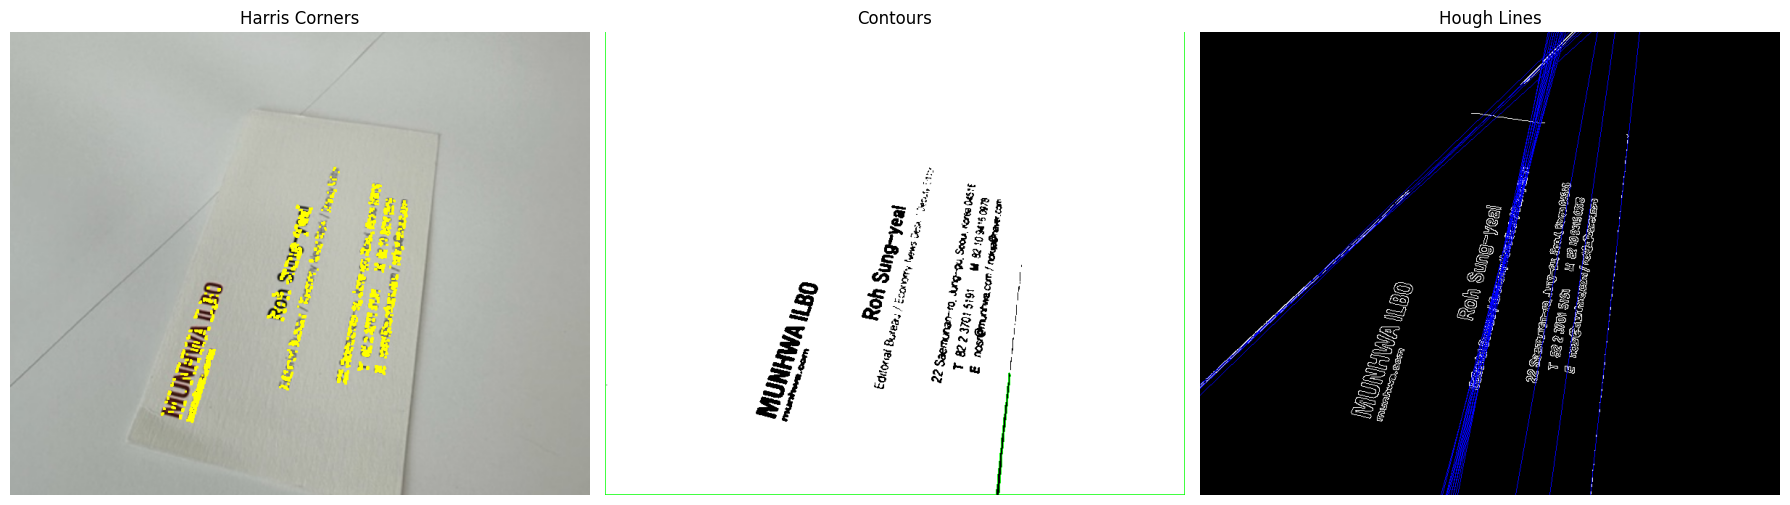

In [14]:
# BC14
idx_14 = 14
image = img_list[idx_14-1].copy()

base_width = 800
height = int(image.shape[0] * base_width / image.shape[1])
resized = cv2.resize(image, (base_width, height))

# 상하단 20% 제거
h = resized.shape[0]
cropped = resized[int(h * 0.2):int(h * 0.8), :]

# Grayscale
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)

# Corner Detection (Harris)
gray_float = np.float32(gray)
dst = cv2.cornerHarris(gray_float, blockSize=2, ksize=3, k=0.04)
dst = cv2.dilate(dst, None)
corner_mask = dst > 0.01 * dst.max()

corner_vis = cropped.copy()
corner_vis[corner_mask] = [0, 255, 255]

# Contours
_, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
contour_vis = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_vis, contours, -1, (0, 255, 0), 1)

# Line Detection (HoughLines)
edges = cv2.Canny(gray, 50, 150, apertureSize=3)
lines = cv2.HoughLines(edges, 1, np.pi / 180, 120)
line_vis = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
if lines is not None:
    for rho, theta in lines[:, 0]:
        a, b = np.cos(theta), np.sin(theta)
        x0, y0 = a * rho, b * rho
        pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
        pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
        cv2.line(line_vis, pt1, pt2, (255, 0, 0), 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(cv2.cvtColor(corner_vis, cv2.COLOR_BGR2RGB))
axes[0].set_title("Harris Corners")
axes[0].axis("off")

axes[1].imshow(cv2.cvtColor(contour_vis, cv2.COLOR_BGR2RGB))
axes[1].set_title("Contours")
axes[1].axis("off")

axes[2].imshow(cv2.cvtColor(line_vis, cv2.COLOR_BGR2RGB))
axes[2].set_title("Hough Lines")
axes[2].axis("off")

plt.tight_layout()
plt.show()

In [15]:
# BC14
idx_14 = 14
image = img_list[idx_14-1].copy()

base_width = 800
height = int(image.shape[0] * base_width / image.shape[1])
resized = cv2.resize(image, (base_width, height))

# 상하단 20% 제거
h = resized.shape[0]
cropped = resized[int(h * 0.2):int(h * 0.8), :]

# Grayscale 및 Harris Corner Detection
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
gray_float = np.float32(gray)
dst = cv2.cornerHarris(gray_float, blockSize=2, ksize=3, k=0.04)
dst = cv2.dilate(dst, None)
corner_mask = dst > 0.01 * dst.max()

# Corner Points
corner_points = np.argwhere(corner_mask)
corner_points = np.fliplr(corner_points)  # (y, x) -> (x, y)

# If corner is very small, exception
if len(corner_points) < 4:
    print("Small Corner.")
    exit()

# Min Area Rect
rect = cv2.minAreaRect(corner_points.astype(np.float32))
box = cv2.boxPoints(rect)
box = np.array(sorted(box, key=lambda p: (p[1], p[0])))  # y 기준 정렬

# 상단 20% 잘린 만큼 y좌표 보정
box[:, 1] += int(h * 0.2)

# Warping
def order_points_clock(pts):
    center = np.mean(pts, axis=0)
    def angle(p): return np.arctan2(p[1] - center[1], p[0] - center[0])
    return np.array(sorted(pts, key=angle), dtype="float32")

ordered_box = order_points_clock(box)
w1 = np.linalg.norm(ordered_box[0] - ordered_box[1])
w2 = np.linalg.norm(ordered_box[2] - ordered_box[3])
h1 = np.linalg.norm(ordered_box[0] - ordered_box[3])
h2 = np.linalg.norm(ordered_box[1] - ordered_box[2])
w, h = int(max(w1, w2)), int(max(h1, h2))

dst_pts = np.array([[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1]], dtype="float32")
m = cv2.getPerspectiveTransform(ordered_box, dst_pts)
warped = cv2.warpPerspective(resized, m, (w, h))

corner_overlay = cropped.copy()
for pt in corner_points:
    cv2.circle(corner_overlay, tuple(pt), 2, (0, 255, 0), -1)
corner_vis = resized.copy()
for pt in box.astype(int):
    cv2.circle(corner_vis, tuple(pt), 5, (0, 255, 255), -1)
cv2.polylines(corner_vis, [box.astype(int)], isClosed=True, color=(0, 0, 255), thickness=2)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].set_title("20% Cropped")
axes[0].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
axes[0].axis("off")

axes[1].set_title("Harris Corners")
axes[1].imshow(cv2.cvtColor(corner_overlay, cv2.COLOR_BGR2RGB))
axes[1].axis("off")

axes[2].set_title("MinAreaRect on Full Image")
axes[2].imshow(cv2.cvtColor(corner_vis, cv2.COLOR_BGR2RGB))
axes[2].axis("off")

axes[3].set_title("Warped Result")
axes[3].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
axes[3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_14}_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_14}_warped.png"), warped)
print(f"Saved: {success}")
# plt.show()

Saved: True


In [16]:
# BC14
idx_14 = 14
image = img_list[idx_14-1].copy()
base_width = 800
height = int(image.shape[0] * base_width / image.shape[1])
resized = cv2.resize(image, (base_width, height))

h = resized.shape[0]
cropped = resized[int(h * 0.2):int(h * 0.8), :]

# Grayscale , Harris Corner
gray = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
gray_float = np.float32(gray)
dst = cv2.cornerHarris(gray_float, 2, 3, 0.04)
dst = cv2.dilate(dst, None)
corner_mask = dst > 0.01 * dst.max()
corner_coords = np.argwhere(corner_mask)
corner_coords = np.flip(corner_coords, axis=1).astype(np.int32)  # (y,x) -> (x,y)

# Convex Hull, 사변형 근사
hull = cv2.convexHull(corner_coords)
epsilon = 0.02 * cv2.arcLength(hull, True)
approx = cv2.approxPolyDP(hull, epsilon, True)

vis = cropped.copy()
cv2.drawContours(vis, [hull], -1, (0, 255, 0), 2)
if len(approx) == 4:
    cv2.polylines(vis, [approx], isClosed=True, color=(0, 0, 255), thickness=3)

def get_patch(img, x, y, size=40):
    return img[y:y+size, x:x+size]

patch_x, patch_y, patch_size = 176, 286, 40
texture_patch = get_patch(cropped, patch_x, patch_y, patch_size)

mask = np.zeros(cropped.shape[:2], dtype=np.uint8)
cv2.drawContours(mask, [approx], -1, 255, -1)
card = np.zeros_like(cropped)
card[mask == 255] = cropped[mask == 255]
card_rot = cv2.rotate(card, cv2.ROTATE_90_CLOCKWISE)
mask_rot = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)

h_card, w_card = card_rot.shape[:2]
tile_h = int(np.ceil(h_card / patch_size))
tile_w = int(np.ceil(w_card / patch_size))
texture_tiled = np.tile(texture_patch, (tile_h, tile_w, 1))
bg_img_final = texture_tiled[:h_card, :w_card, :]

blur_ksize = (49, 49)
bg_img_blur = cv2.GaussianBlur(bg_img_final, blur_ksize, 0)

mask3 = cv2.merge([mask_rot]*3)
result = bg_img_blur.copy()
np.copyto(result, card_rot, where=mask3.astype(bool))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
axes[0].set_title("Convex Hull & Approximated Quadrilateral")
axes[0].imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
axes[0].axis("off")

axes[1].set_title("Card on Blurred Patch BG (Rotated)")
axes[1].imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
axes[1].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_14}_test_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_14}_test_warped.png"), result)
print(f"Saved: {success}")
# plt.show()

Saved: True


In [17]:
# BC14
idx_14 = 14
img = img_list[idx_14-1].copy()

# 같은 크기의 노란색 이미지 만들기 (BGR 기준: (0, 255, 255))
overlay = np.full(img.shape, (0, 255, 255), dtype=np.uint8)

# 알파 블렌딩으로 합성 (alpha: 노란색 강도)
alpha = 0.05  # 0.0 ~ 1.0 사이 값, 높을수록 노란 색조 진해짐
result = cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)

mode_color = get_mode_hsv(result)
lower_white = np.array(mode_color[0]-10, dtype=np.uint8)
upper_white = np.array(mode_color[0]+10, dtype=np.uint8)

# 이미지에서 하얀색 제외하여 지우기
output_image = keep_specific_color(result, lower_white,upper_white)
gray = cv2.cvtColor(output_image, cv2.COLOR_BGR2GRAY)

# 중간값 필터링
filtered_image = cv2.medianBlur(gray, 5)
# Harris 코너 검출 수행
corner_response = cv2.cornerHarris(filtered_image, blockSize=2, ksize=3, k=0.04)
corner_response = cv2.dilate(corner_response, None)

# 다양한 임계값 시도
# threshold_values = [0.001, 0.01, 0.05, 0.75, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4 ,0.5, 0.75, 1]

# for threshold in threshold_values:
#     # 코너 픽셀의 좌표 찾기
#     corners = np.argwhere(corner_response > threshold * corner_response.max())
#     corners = corners.reshape(-1, 2).astype(np.float32)

#     print(f"Threshold: {threshold}, 검출된 코너 수: {len(corners)}")

#     # (나머지 원근 변환 코드는 여기에 적용)
#     # min_x, min_y, max_x, max_y 계산
#     min_x, min_y, max_x, max_y = None, None, None, None
#     if len(corners) > 0:
#         for point in corners:
#             x = point[1]
#             y = point[0]
#             if min_x is None or x < min_x[0]:
#                 min_x = (x, y)
#             if min_y is None or y < min_y[1]:
#                 min_y = (x, y)
#             if max_x is None or x > max_x[0]:
#                 max_x = (x, y)
#             if max_y is None or y > max_y[1]:
#                 max_y = (x, y)

#         # 검출된 코너가 4개 이상일 경우에만 원근 변환 시도
#         if len(corners) >= 4 and min_x is not None and min_y is not None and max_x is not None and max_y is not None:
#              dw, dh = 900, 530
#              points = np.array([[min_x], [min_y], [max_x], [max_y]])
#              # reorderPts 함수는 사용자의 코드를 따릅니다.
#              srcQuad = reorderPts(points.reshape(4, 2).astype(np.float32))
#              dstQuad = np.array([[0, dh], [dw, dh], [dw, 0], [0, 0]], np.float32)

#              # 원근 변환 수행
#              pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
#              dst = cv2.warpPerspective(img.copy(), pers, (dw, dh), flags=cv2.INTER_CUBIC) # img는 원본 이미지입니다.

#              # 결과 시각화
#              plt.imshow(dst, cmap='gray')
#         else:
#             print("4개의 모서리를 찾지 못했거나 코너가 부족합니다.")
#     else:
#         print("코너가 검출되지 않았습니다.")

# 코너 픽셀의 좌표 찾기
threshold = 0.5
corners = np.argwhere(corner_response > threshold * corner_response.max())
corners = corners.reshape(-1, 2).astype(np.float32)

# 결과 좌표 리스트 저장
corner_points_list = corners.tolist()

min_x = None
min_y = None
max_x = None
max_y = None
for point in corners:
    x = point[1]
    y = point[0]
    if min_x is None or x < min_x[0]:
        min_x = (x, y)
    if min_y is None or y < min_y[1]:
        min_y = (x, y)
    if max_x is None or x > max_x[0]:
        max_x = (x, y)
    if max_y is None or y > max_y[1]:
        max_y = (x, y)

dw, dh = 900, 530
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, dh], [dw, dh], [dw, 0], [0, 0]], np.float32)
points = np.array([[min_x], [min_y], [max_x], [max_y]])
srcQuad = reorderPts(points.reshape(4, 2).astype(np.float32))
dst = np.zeros((dh, dw), np.uint8)
pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst_color = cv2.warpPerspective(img, pers, (dw, dh), flags=cv2.INTER_CUBIC)
dst_color = cv2.rotate(dst_color, cv2.ROTATE_180)

dst = cv2.cvtColor(dst_color, cv2.COLOR_BGR2GRAY)
dst = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
dst = cv2.rotate(dst, cv2.ROTATE_180)
edges = cv2.Canny(dst, 100, 255)

orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
corner_norm = cv2.normalize(corner_response, None, 0, 255, cv2.NORM_MINMAX)
overlay = cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
dst_color_vis = cv2.cvtColor(dst_color, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(2, 4, figsize=(20, 10))
axs = axs.ravel()
titles = [
    f"BC{idx_14} Original", "Yellow Overlay", "Blended", "White Removed",
    "Median Filtered", "Harris Corners", "Final", ""
]
images = [
    orig_rgb, overlay, result, output_image,
    filtered_image, corner_norm, dst_color_vis, None
]
for i in range(7):
    if len(images[i].shape) == 2:
        axs[i].imshow(images[i], cmap='gray')
    else:
        axs[i].imshow(images[i])
    axs[i].set_title(titles[i])
    axs[i].axis('off')
axs[7].axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_14}_another_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_14}_another_warped.png"), dst_color)
print(f"Saved: {success}")
# plt.show()

Saved: True


# BC15

In [18]:
# BC15
idx_15 = 15
img = img_list[idx_15-1].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

edged = cv2.Canny(gray, 100, 250)

contours, hierarchy = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
min_area = 5000
selected_contours = []
for contour in contours:
    if cv2.contourArea(contour) > min_area:
        selected_contours.append(contour)

min_x = None
min_y = None
max_x = None
max_y = None
for contour in selected_contours:
    for point in contour:
        x = point[0][0]
        y = point[0][1]
        if min_x is None or x < min_x[0]:
            min_x = (x, y)
        if min_y is None or y < min_y[1]:
            min_y = (x, y)
        if max_x is None or x > max_x[0]:
            max_x = (x, y)
        if max_y is None or y > max_y[1]:
            max_y = (x, y)
            
dw, dh = 900, 530
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)
points = np.array([[min_x], [min_y], [max_x], [max_y]])
srcQuad = reorderPts(points.reshape(4, 2).astype(np.float32))
dst = np.zeros((dh, dw), np.uint8)
pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst = cv2.warpPerspective(img, pers, (dw, dh), flags=cv2.INTER_CUBIC)

dst = cv2.cvtColor(dst, cv2.COLOR_BGR2GRAY)
dst = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
dst_color = cv2.warpPerspective(img, pers, (dw, dh), flags=cv2.INTER_CUBIC)

contour_img = img.copy()
cv2.drawContours(contour_img, selected_contours, -1, (0, 255, 0), 2)
contour_img_rgb = cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(orig_rgb)
axs[0].set_title(f"BC{idx_15} Original")
axs[0].axis("off")

axs[1].imshow(edged, cmap="gray")
axs[1].set_title("Warped -> Threshold -> Canny")
axs[1].axis("off")

axs[2].imshow(contour_img_rgb)
axs[2].set_title("Detected Contours")
axs[2].axis("off")

axs[3].imshow(cv2.cvtColor(dst_color, cv2.COLOR_BGR2RGB))
axs[3].set_title("Warped Color")
axs[3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_15}_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_15}_warped.png"), dst_color)
print(f"Saved: {success}")
# plt.show()

Saved: True


In [19]:
# BC15
idx_15 = 15
image = img_list[idx_15-1].copy()

# Preprocessing
base_width = 800
height = int(image.shape[0] * base_width / image.shape[1])
resized = cv2.resize(image, (base_width, height))
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

median = cv2.medianBlur(gray, 5)
blurred = cv2.GaussianBlur(median, (9, 9), 0)
kernel = np.ones((3, 3), np.uint8)
closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, kernel, iterations=1)
edges = cv2.Canny(closed, 60, 180)

# Delete Corner
gray_float = np.float32(median)
dst = cv2.cornerHarris(gray_float, 2, 3, 0.04)
dst_dilated = cv2.dilate(dst, None)
corner_coords = np.argwhere(dst_dilated > 0.01 * dst_dilated.max())

edges_removed = edges.copy()
corner_mask = np.zeros_like(edges, dtype=np.uint8)
for y, x in corner_coords:
    y1, y2 = max(0, y-1), min(edges.shape[0], y+2)
    x1, x2 = max(0, x-1), min(edges.shape[1], x+2)
    edges_removed[y1:y2, x1:x2] = 0
    corner_mask[y1:y2, x1:x2] = 255

non_corner_mask = cv2.bitwise_not(corner_mask)
edges_dilatable = cv2.bitwise_and(edges_removed, edges_removed, mask=non_corner_mask)
edges_dilated = cv2.dilate(edges_dilatable, np.ones((3, 3), np.uint8), iterations=1)
final_edges = cv2.bitwise_or(edges_dilated, cv2.bitwise_and(edges_removed, corner_mask))

 # Line Detection
lines_std = cv2.HoughLines(final_edges, 1, np.pi / 180, threshold=130) # Hough Line threshold 조절
lines_filtered = filter_similar_lines_by_angle_rho(lines_std) if lines_std is not None else []

vis_all_lines = cv2.cvtColor(final_edges, cv2.COLOR_GRAY2BGR)
for rho, theta in lines_std[:, 0]:
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
    cv2.line(vis_all_lines, pt1, pt2, (255, 0, 0), 1)

vis_lines = cv2.cvtColor(final_edges, cv2.COLOR_GRAY2BGR)
line_segments = []
for rho, theta in lines_filtered:
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
    cv2.line(vis_lines, pt1, pt2, (0, 0, 255), 2)
    line_segments.append((pt1, pt2))

# Intersections
intersections = []
for (p1, p2), (q1, q2) in itertools.combinations(line_segments, 2):
    pt = compute_intersection_from_points(p1, p2, q1, q2)
    if pt is not None:
        x, y = pt
        if 0 <= x < base_width and 0 <= y < height:
            intersections.append(pt)

vis_intersections = vis_lines.copy()
for pt in intersections:
    cv2.circle(vis_intersections, tuple(pt.astype(int)), 12, (0, 255, 0), -1)

# Quad Detection and Warp
quads = find_quadrilateral_candidates_ransac(intersections)
best_quad = select_best_quad_combined(quads, resized.shape)

vis_quad = resized.copy()
if best_quad is not None:
    cv2.polylines(vis_quad, [best_quad.astype(int)], isClosed=True, color=(0, 255, 0), thickness=3)
    warped = warp_perspective_auto_size(resized, best_quad)
    cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_15}_another_warped.png"), warped)
else:
    warped = np.zeros((530, 900, 3), dtype=np.uint8)
    cv2.putText(vis_quad, "No quadrilateral", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 0, 255), 2)

# Visualization
fig, axes = plt.subplots(3, 3, figsize=(18, 12))
titles = [f"BC{idx_15} Original", "Corner Mask", "Edges Removed",
          "Final Edges", "All Hough Lines", "Filtered Lines",
          "Intersections", "Detected Quadrilateral", "Warped Result"]
images = [resized, corner_mask, edges_removed,
          final_edges, vis_all_lines, vis_lines,
          vis_intersections, vis_quad, warped]

for ax, img, title in zip(axes.flat, images, titles):
    if len(img.shape) == 2:
        ax.imshow(img, cmap='gray')
    else:
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_15}_another_result.png"))
plt.close()

# BC16

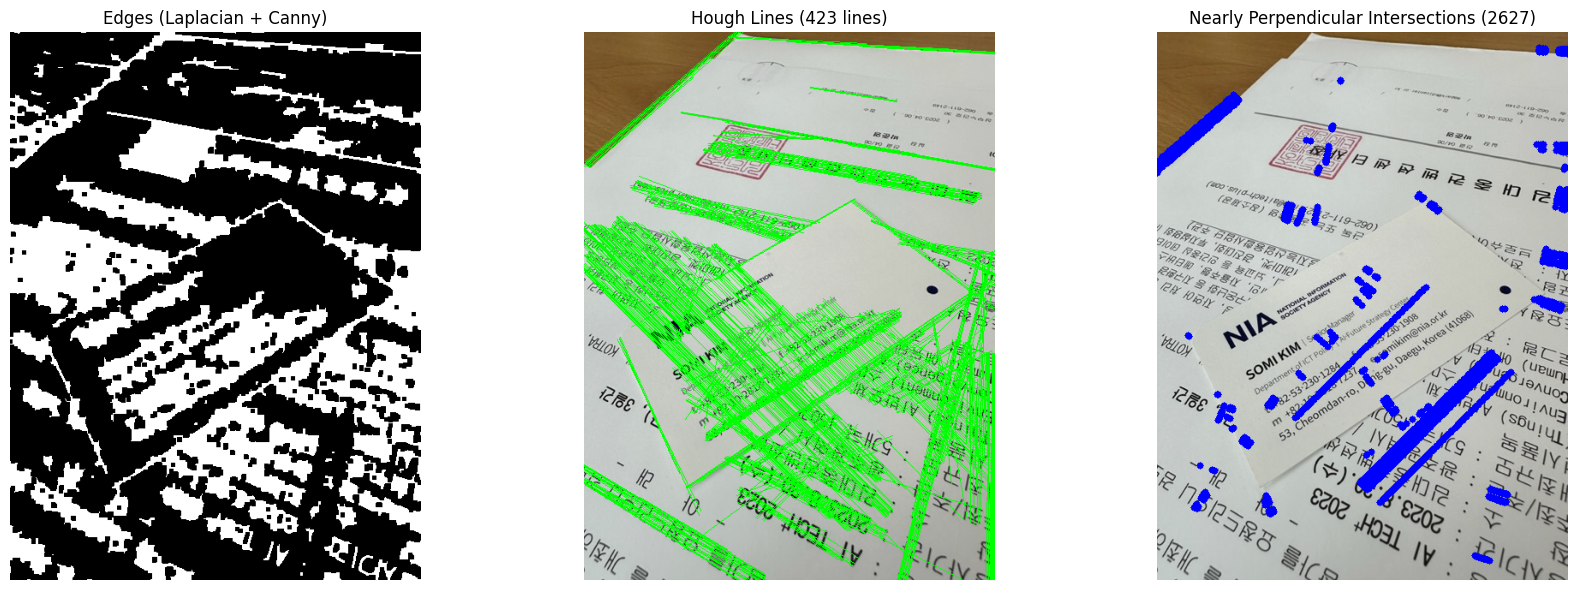

In [ ]:
# BC16
idx_16 = 16
img = img_list[idx_16-1].copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# CLAHE -> Laplacian -> Canny -> Morph
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
gray_eq = clahe.apply(gray)
lap = cv2.Laplacian(gray_eq, cv2.CV_8U)
edges = cv2.Canny(lap, 50, 150)
edges = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, np.ones((5, 5), np.uint8))

# Line Detection
lines = cv2.HoughLinesP(edges, 1, np.pi/180, 100, minLineLength=100, maxLineGap=20)
segments = [l[0] for l in lines] if lines is not None else []

# Compute Intersection
def compute_intersection(l1, l2):
    x1, y1, x2, y2 = l1
    x3, y3, x4, y4 = l2
    A = np.array([[x2-x1, -(x4-x3)], [y2-y1, -(y4-y3)]])
    b = np.array([x3 - x1, y3 - y1])
    if np.abs(np.linalg.det(A)) < 1e-5:
        return None
    t = np.linalg.solve(A, b)
    pt = np.array([x1, y1]) + t[0] * np.array([x2-x1, y2-y1])
    return tuple(pt.astype(int))

def angle_between_two(l1, l2):
    v1 = np.array([l1[2]-l1[0], l1[3]-l1[1]])
    v2 = np.array([l2[2]-l2[0], l2[3]-l2[1]])
    angle = np.arccos(np.clip(np.dot(v1, v2)/(np.linalg.norm(v1)*np.linalg.norm(v2)), -1, 1))
    return np.degrees(angle)

intersections = []
for l1, l2 in itertools.combinations(segments, 2):
    ang = angle_between_two(l1, l2)
    if 85 <= ang <= 95:
        pt = compute_intersection(l1, l2)
        if pt and 0 <= pt[0] < img.shape[1] and 0 <= pt[1] < img.shape[0]:
            intersections.append(pt)

# Visualize
line_img = img.copy()
for x1, y1, x2, y2 in segments:
    cv2.line(line_img, (x1, y1), (x2, y2), (0, 255, 0), 1)

intersect_img = img.copy()
for x, y in intersections:
    cv2.circle(intersect_img, (x, y), 4, (255, 0, 0), -1)

fig, axs = plt.subplots(1, 3, figsize=(18, 6))
axs[0].imshow(edges, cmap="gray")
axs[0].set_title("Edges (Laplacian + Canny)")
axs[0].axis("off")

axs[1].imshow(cv2.cvtColor(line_img, cv2.COLOR_BGR2RGB))
axs[1].set_title(f"Hough Lines ({len(segments)} lines)")
axs[1].axis("off")

axs[2].imshow(cv2.cvtColor(intersect_img, cv2.COLOR_BGR2RGB))
axs[2].set_title(f"Nearly Perpendicular Intersections ({len(intersections)})")
axs[2].axis("off")

plt.tight_layout()
plt.show()

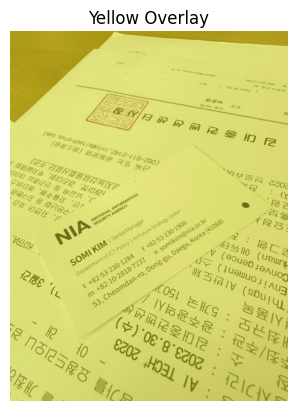

In [21]:
# BC16
idx_16 = 16
img = img_list[idx_16-1].copy()

# 같은 크기의 노란색 이미지 만들기 (BGR 기준: (0, 255, 255))
overlay = np.full(img.shape, (0, 255, 255), dtype=np.uint8)

# 알파 블렌딩으로 합성 (alpha: 노란색 강도)
alpha = 0.4 # 0.0 ~ 1.0 사이 값, 높을수록 노란 색조 진해짐
result = cv2.addWeighted(img, 1 - alpha, overlay, alpha, 0)

plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Yellow Overlay")
plt.show()

In [22]:
# BC16
idx_16 = 16
img = img_list[idx_16-1].copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 중간값 필터링
filtered_image = cv2.medianBlur(gray, 5)
# Harris 코너 검출 수행
corner_response = cv2.cornerHarris(filtered_image, blockSize=2, ksize=3, k=0.04)
corner_response = cv2.dilate(corner_response, None)

# 코너 픽셀의 좌표 찾기
threshold = 0.005  # 코너로 판단할 응답 값 임계값, 이게 제일 적합하다고 판단
corners = np.argwhere(corner_response > threshold * corner_response.max())
corners = corners.reshape(-1, 2).astype(np.float32)

# 결과 좌표 리스트 저장
corner_points_list = corners.tolist()

min_x = None
min_y = None
max_x = None
max_y = None
for point in corners:
    x = point[1]
    y = point[0]
    if min_x is None or x < min_x[0]:
        min_x = (x, y)
    if min_y is None or y < min_y[1]:
        min_y = (x, y)
    if max_x is None or x > max_x[0]:
        max_x = (x, y)
    if max_y is None or y > max_y[1]:
        max_y = (x, y)

dw, dh = 900, 530
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, dh], [dw, dh], [dw, 0], [0, 0]], np.float32)
points = np.array([[min_x], [min_y], [max_x], [max_y]])
srcQuad = reorderPts(points.reshape(4, 2).astype(np.float32))
dst = np.zeros((dh, dw), np.uint8)
pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
dst_t = cv2.warpPerspective(img, pers, (dw, dh), flags=cv2.INTER_CUBIC)

dst = cv2.cvtColor(dst_t, cv2.COLOR_BGR2GRAY)
dst = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
edges = cv2.Canny(dst, 100, 255)

h, w = img.shape[:2]

dst_t = dst_t[:, w//2:]
dst_t = dst_t[:, w//2:]
dst_t = cv2.rotate(dst_t, cv2.ROTATE_90_CLOCKWISE)
h, w = dst_t.shape[:2]
left_w = (w * 2) // 3 # 왼쪽 2/3 너비
dst_left_two_thirds = dst_t[:, :left_w]
dst_color = cv2.cvtColor(dst_left_two_thirds, cv2.COLOR_BGR2RGB)

edges = edges[:, w//2:] # 모든 행, 가운데 열부터 끝까지 (오른쪽 반절)
edges = edges[:, w//2:] # 모든 행, 가운데 열부터 끝까지 (또 거기서 오른쪽 반절)
edges = cv2.rotate(edges, cv2.ROTATE_90_CLOCKWISE)
h, w = edges.shape[:2]
left_w = (w * 2) // 3 # 왼쪽 2/3 너비

# 왼쪽 2/3만 크롭해서 새로운 이미지로 만들기
left_two_thirds = edges[:, :left_w]

corner_overlay = img.copy()
for (y, x) in corners.astype(int):
    cv2.circle(corner_overlay, (x, y), 4, (0, 255, 0), -1)
corner_overlay_rgb = cv2.cvtColor(corner_overlay, cv2.COLOR_BGR2RGB)
orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(orig_rgb)
axs[0].set_title(f"BC{idx_16} Original")
axs[0].axis("off")

axs[1].imshow(corner_overlay_rgb)
axs[1].set_title("Harris Corners")
axs[1].axis("off")

axs[2].imshow(left_two_thirds, cmap="gray")
axs[2].set_title("Warped Binary")
axs[2].axis("off")

axs[3].imshow(dst_color)
axs[3].set_title("Warped Result")
axs[3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_16}_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_16}_warped.png"), dst_left_two_thirds)
print(f"Saved: {success}")
# plt.show()

Saved: True


# BC17 (X)

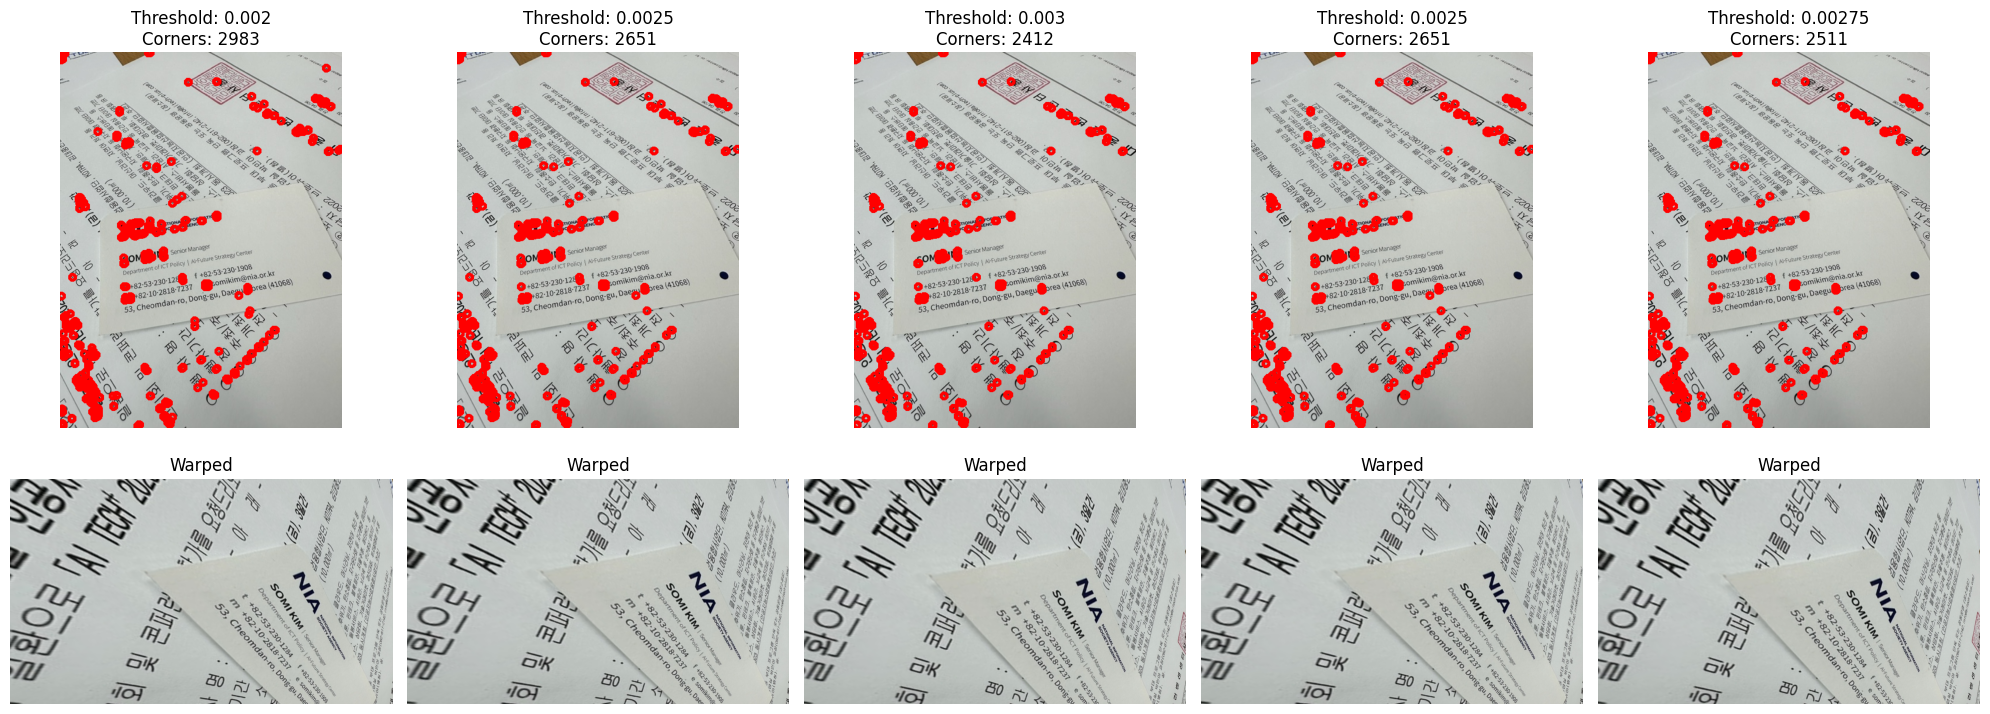

In [23]:
# BC17
idx_17 = 17
img = img_list[idx_17-1].copy()

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
t = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
t = cv2.GaussianBlur(t, (7, 7), 0)
t = cv2.bilateralFilter(t, 9, 75, 75)
t = cv2.edgePreservingFilter(t, flags=1, sigma_s=45, sigma_r=0.2)
preprocessed = t.copy()

corner_response = cv2.cornerHarris(preprocessed, blockSize=2, ksize=3, k=0.04)
corner_response = cv2.dilate(corner_response, None)

# 다양한 임계값 시도
threshold_values = [0.002, 0.0025, 0.003, 0.0025, 0.00275]

corner_imgs = []
warped_imgs = []
titles = []

for threshold in threshold_values:
    # 코너 추출
    corners = np.argwhere(corner_response > threshold * corner_response.max())
    corners = corners.reshape(-1, 2).astype(np.float32)
    titles.append(f"Threshold: {threshold}\nCorners: {len(corners)}")
    
    # 코너 표시 이미지
    img_corners = img.copy()
    img_corners = cv2.cvtColor(img_corners, cv2.COLOR_BGR2RGB)
    for point in corners:
        x, y = int(point[1]), int(point[0])
        cv2.circle(img_corners, (x, y), 5, (255, 0, 0), 2)
    corner_imgs.append(img_corners)

    min_x, min_y, max_x, max_y = None, None, None, None
    if len(corners) > 0:
        for point in corners:
            x = point[1]
            y = point[0]
            if min_x is None or x < min_x[0]: min_x = (x, y)
            if min_y is None or y < min_y[1]: min_y = (x, y)
            if max_x is None or x > max_x[0]: max_x = (x, y)
            if max_y is None or y > max_y[1]: max_y = (x, y)

        # 4개 이상 코너만
        if len(corners) >= 4 and min_x and min_y and max_x and max_y:
            dw, dh = 900, 530
            points = np.array([[min_x], [min_y], [max_x], [max_y]])
            srcQuad = reorderPts(points.reshape(4, 2).astype(np.float32))
            dstQuad = np.array([[0, dh], [dw, dh], [dw, 0], [0, 0]], np.float32)
            pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
            dst = cv2.warpPerspective(img.copy(), pers, (dw, dh), flags=cv2.INTER_CUBIC)
            dst = cv2.rotate(dst, cv2.ROTATE_180)
        else:
            dst = np.ones((530, 900, 3), dtype=np.uint8) * 255
    else:
        dst = np.ones((530, 900, 3), dtype=np.uint8) * 255
    warped_imgs.append(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))

N = len(threshold_values)
fig, axes = plt.subplots(2, N, figsize=(4*N, 8))
for i in range(N):
    axes[0, i].imshow(corner_imgs[i])
    axes[0, i].set_title(titles[i])
    axes[0, i].axis('off')

    axes[1, i].imshow(warped_imgs[i])
    axes[1, i].set_title("Warped")
    axes[1, i].axis('off')
plt.tight_layout()
plt.show()

# BC18

In [24]:
# BC18
idx_18 = 18
img = img_list[idx_18-1].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
binary = cv2.threshold(gray, 235, 255, cv2.THRESH_BINARY)[1]

# 외곽선 검출
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_area = 5000
selected_contours = []
for contour in contours:
    if cv2.contourArea(contour) > min_area:
        selected_contours.append(contour)

# contours 중 가장 큰 4개를 선택하여 다각형 근사(approximation) 수행
approx_contours = []
for contour in selected_contours:
    epsilon = 0.02 * cv2.arcLength(contour, True)
    approx = cv2.approxPolyDP(contour, epsilon, True)
    if len(approx) == 4:
        approx_contours.append(approx)

largest_contour = max(approx_contours, key=cv2.contourArea)

# 결과 이미지 출력
dw, dh = 900, 530
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)
dst = np.zeros((dh, dw), np.uint8)
srcQuad = reorderPts(largest_contour.reshape(4, 2).astype(np.float32))
pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
warped_color = cv2.warpPerspective(img, pers, (dw, dh), flags=cv2.INTER_CUBIC)

gray_warped = cv2.cvtColor(warped_color, cv2.COLOR_BGR2GRAY)
binary_warped = cv2.threshold(gray_warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
# 이미지에 침식(Erosion)을 적용
edges = cv2.Canny(binary_warped, 100, 255)

orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
contour_overlay = img.copy()
cv2.drawContours(contour_overlay, selected_contours, -1, (0, 255, 0), 2)
contour_overlay_rgb = cv2.cvtColor(contour_overlay, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(orig_rgb)
axs[0].set_title(f"BC{idx_18} Original")
axs[0].axis("off")

axs[1].imshow(binary, cmap="gray")
axs[1].set_title("Binary")
axs[1].axis("off")

axs[2].imshow(contour_overlay_rgb)
axs[2].set_title("Detected Contours")
axs[2].axis("off")

axs[3].imshow(cv2.cvtColor(warped_color, cv2.COLOR_BGR2RGB))
axs[3].set_title("Warped Color")
axs[3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_18}_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_18}_warped.png"), warped_color)
print(f"Saved: {success}")
# plt.show()

Saved: True


In [25]:
# BC18
idx_18 = 18
image = img_list[idx_18-1].copy()

base_width = 800
height = int(image.shape[0] * base_width / image.shape[1])
resized = cv2.resize(image, (base_width, height))
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)

# Filtering
median = cv2.medianBlur(gray, 5)
blurred = cv2.GaussianBlur(median, (9, 9), 0)
closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, np.ones((3, 3), np.uint8), iterations=1)

# 밝기 마스크 기반 엣지
brightness_mask = cv2.inRange(closed, 230, 255) # 밝은 배경만 유지
edges = cv2.Canny(brightness_mask, 60, 180)

# Delete Corner
gray_float = np.float32(median)
dst = cv2.cornerHarris(gray_float, 2, 3, 0.04)
dst_dilated = cv2.dilate(dst, None)
corner_coords = np.argwhere(dst_dilated > 0.01 * dst_dilated.max())

edges_removed = edges.copy()
corner_mask = np.zeros_like(edges, dtype=np.uint8)
for y, x in corner_coords:
    y1, y2 = max(0, y-1), min(edges.shape[0], y+2)
    x1, x2 = max(0, x-1), min(edges.shape[1], x+2)
    edges_removed[y1:y2, x1:x2] = 0
    corner_mask[y1:y2, x1:x2] = 255

non_corner_mask = cv2.bitwise_not(corner_mask)
edges_dilatable = cv2.bitwise_and(edges_removed, edges_removed, mask=non_corner_mask)
edges_dilated = cv2.dilate(edges_dilatable, np.ones((3, 3), np.uint8), iterations=1)
final_edges = cv2.bitwise_or(edges_dilated, cv2.bitwise_and(edges_removed, corner_mask))

# Line Detection (Hough Transform)
lines = cv2.HoughLines(final_edges, 1, np.pi / 180, 150)

filtered_lines = []
if lines is not None:
    for rho, theta in lines[:, 0]:
        similar = False
        for r2, t2 in filtered_lines:
            if abs(np.rad2deg(t2 - theta)) < 5 and abs(r2 - rho) < 170:
                similar = True
                break
        if not similar:
            filtered_lines.append((rho, theta))

line_segments = []
for rho, theta in filtered_lines:
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    pt1 = (int(x0 + 1000 * (-b)), int(y0 + 1000 * a))
    pt2 = (int(x0 - 1000 * (-b)), int(y0 - 1000 * a))
    line_segments.append((pt1, pt2))

# Compute Intersection
intersections = []
for (p1, p2), (q1, q2) in itertools.combinations(line_segments, 2):
    pt = compute_intersection_from_points(p1, p2, q1, q2)
    if pt is not None:
        x, y = pt
        if 0 <= x < base_width and 0 <= y < height:
            intersections.append(pt)

# Quad Detection
quads = find_quadrilateral_candidates_ransac(intersections)
best_quad = select_best_quad_combined(quads, resized.shape)

# Perspective Warp
if best_quad is not None:
    warped = warp_perspective_auto_size(resized, best_quad)
else:
    warped = np.zeros((530, 900, 3), dtype=np.uint8)

# Visualize
vis_img = resized.copy()
for pt1, pt2 in line_segments:
    cv2.line(vis_img, pt1, pt2, (255, 0, 0), 1)
for pt in intersections:
    cv2.circle(vis_img, tuple(pt.astype(int)), 6, (0, 255, 255), -1)
for quad in quads:
    cv2.polylines(vis_img, [quad.astype(int)], isClosed=True, color=(0, 255, 0), thickness=2)
if best_quad is not None:
    cv2.polylines(vis_img, [best_quad.astype(int)], isClosed=True, color=(0, 0, 255), thickness=3)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(brightness_mask, cmap="gray")
axs[0].set_title("Brightness Mask")
axs[0].axis("off")

axs[1].imshow(final_edges, cmap="gray")
axs[1].set_title("Final Edges")
axs[1].axis("off")

axs[2].imshow(cv2.cvtColor(vis_img, cv2.COLOR_BGR2RGB))
axs[2].set_title("Hough + Intersections + Quads")
axs[2].axis("off")

axs[3].imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
axs[3].set_title("Warped Result")
axs[3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_18}_another_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_18}_another_warped.png"), warped)
print(f"Saved: {success}")
# plt.show()

Saved: True


# BC19

In [26]:
# BC19
idx_19 = 19
img = img_list[idx_19-1].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
t = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
t = cv2.GaussianBlur(t, (7, 7), 0)
t = cv2.bilateralFilter(t, 9, 75, 75)
t = cv2.edgePreservingFilter(t, flags=1, sigma_s=45, sigma_r=0.2)

edged = cv2.Canny(t, 75, 250, True)
lines = cv2.HoughLines(edged, 1, np.pi/180, 98)

intersections = []
for line in lines:
    rho, theta = line[0]
    a, b = np.cos(theta), np.sin(theta)
    x0, y0 = a * rho, b * rho
    x1, y1 = int(x0 + 1000 * (-b)), int(y0 + 1000 * (a))
    x2, y2 = int(x0 - 1000 * (-b)), int(y0 - 1000 * (a))
    intersections.append((x1, y1, x2, y2))

points = []
for i in range(len(intersections)):
    for j in range(i+1, len(intersections)):
        x1, y1, x2, y2 = intersections[i]
        x3, y3, x4, y4 = intersections[j]

        denominator = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
        if denominator != 0:
            px = int(((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/denominator)
            py = int(((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/denominator)
            if px > 0 and py > 0 and px < 480 and py < 640: # 양수인 점들만 추가
                points.append((px, py))

x_min = min(points, key=lambda p: p[0])[0]
x_max = max(points, key=lambda p: p[0])[0]
y_min = min(points, key=lambda p: p[1])[1]
y_max = max(points, key=lambda p: p[1])[1]

corner_points = points.copy()

tolerance = 10
closest_points = [(x, y) for x, y in points if abs(x - x_min) <= tolerance]
mi_x_ma_y = max(closest_points, key=lambda p: p[1])[1]
mi_x_mi_y = min(closest_points, key=lambda p: p[1])[1]
closest_points = [(x, y) for x, y in points if abs(x - x_max) <= tolerance]
ma_x_ma_y = max(closest_points, key=lambda p: p[1])[1]
ma_x_mi_y = min(closest_points, key=lambda p: p[1])[1]

top_left = (x_min, mi_x_mi_y)
bottom_left = (x_min, mi_x_ma_y)
top_right = (x_max, ma_x_mi_y)
bottom_right = (x_max, ma_x_ma_y)

dw, dh = 900, 530
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
dstQuad = np.array([[0, 0], [0, dh], [dw, dh], [dw, 0]], np.float32)
points = np.array([[top_right], [top_left], [bottom_left],[bottom_right],])
srcQuad = points.reshape(4,2).astype(np.float32)
dst = np.zeros((dh, dw), np.uint8)
pers = cv2.getPerspectiveTransform(srcQuad, dstQuad)
warped_color = cv2.warpPerspective(img, pers, (dw, dh), flags=cv2.INTER_CUBIC)

gray_warped = cv2.cvtColor(warped_color, cv2.COLOR_BGR2GRAY)
binary = cv2.threshold(gray_warped, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
line_overlay = img.copy()
for x1, y1, x2, y2 in intersections:
    cv2.line(line_overlay, (x1, y1), (x2, y2), (0, 255, 0), 1)
for pt in corner_points:
    if isinstance(pt, tuple) and len(pt) == 2:
        cv2.circle(line_overlay, pt, 4, (255, 0, 0), -1)
line_overlay_rgb = cv2.cvtColor(line_overlay, cv2.COLOR_BGR2RGB)
warped_color_rgb = cv2.cvtColor(warped_color, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 4, figsize=(24, 6))
axs[0].imshow(orig_rgb)
axs[0].set_title(f"BC{idx_19} Original")
axs[0].axis("off")

axs[1].imshow(edged, cmap="gray")
axs[1].set_title("Edge")
axs[1].axis("off")

axs[2].imshow(line_overlay_rgb)
axs[2].set_title("Hough Lines + Intersections")
axs[2].axis("off")

axs[3].imshow(warped_color_rgb)
axs[3].set_title("Warped Color")
axs[3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_19}_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_19}_warped.png"), warped_color)
print(f"Saved: {success}")
# plt.show()

Saved: True


# BC20

In [27]:
# BC20
idx_20 = 20
img = img_list[idx_20-1].copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# 이진화 및 노이즈 제거
t = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1] # Otsu 이진화
t = cv2.GaussianBlur(t, (7, 7), 0) # 가우시안 블러
t = cv2.bilateralFilter(t, 9, 75, 75) # 양방향 필터
t = cv2.edgePreservingFilter(t, flags=1, sigma_s=45, sigma_r=0.2) # edge 보존 필터

# Canny로 edge 검출 및 mask 적용
edged = cv2.Canny(t, 100, 250) # 강한(100)~약한(250) 경계를 검출해 edged에 담음
edged = fmask(edged) # 필요 없는 부분을 마스킹

# HoughLines로 직선 검출
lines = cv2.HoughLines(edged, 1, np.pi/180, 98)
intersections = []
for line in lines:
    rho, theta = line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a * rho
    y0 = b * rho
    x1 = int(x0 + 1000 * (-b))
    y1 = int(y0 + 1000 * (a))
    x2 = int(x0 - 1000 * (-b))
    y2 = int(y0 - 1000 * (a))
    intersections.append((x1, y1, x2, y2))

# 직선들의 교차점 계산
points = []
for i in range(len(intersections)):
    for j in range(i+1, len(intersections)):
        x1, y1, x2, y2 = intersections[i]
        x3, y3, x4, y4 = intersections[j]

        denominator = (x1-x2)*(y3-y4) - (y1-y2)*(x3-x4)
        if denominator != 0: # denominator가 0이 아니어야(평행하지 않아야) 교차점 존재
            px = int(((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/denominator)
            py = int(((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/denominator)
            if px > -100 and py > 0 and px < 480 and py < 640: # 양수인 점들만 추가
                points.append((px, py))
points = np.array(points)

min_x = None
min_y = None
max_x = None
max_y = None
# 네 개의 모서리 찾기
for point in points:
    x = point[0]
    y = point[1]

    if min_x is None or x < min_x[0]: # x가 가장 작은 점
        min_x = (x, y)
    if min_y is None or y < min_y[1]: # y가 가장 작은 점
        min_y = (x, y)
    if max_x is None or x > max_x[0]: # x가 가장 큰 점
        max_x = (x, y)
    if max_y is None or y > max_y[1]: # y가 가장 작은 점
        max_y = (x, y)

dw, dh = 900, 530
# 변환 전 좌표
srcQuad = np.array([[0, 0], [0, 0], [0, 0], [0, 0]], np.float32)
# 변환 후 좌표
dstQuad = np.array([[0, 0], [0, dh], [dw, dh]], np.float32)
points = np.array([[min_y], [min_x], [max_y]])

for intersection in points:
    x, y = intersection[0]

srcQuad = points.reshape(3, 2).astype(np.float32)
dst = np.zeros((dh, dw), np.uint8)

# AFFINE MATRIX 계산 및 이미지 변환
affine_matrix = cv2.getAffineTransform(srcQuad, dstQuad) # 세 개의 점 대응을 기반으로 하는 2×3 어파인 행렬 생성
transformed_image = cv2.warpAffine(img, affine_matrix, (900, 530))

# 변환 후 이진화 & Edge 검출
dst = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2GRAY)
dst = cv2.threshold(dst, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
edges = cv2.Canny(dst, 100, 255)

orig_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
line_overlay = orig_rgb.copy()
for x1, y1, x2, y2 in intersections:
    cv2.line(line_overlay, (x1, y1), (x2, y2), (0, 255, 0), 1)
for pt in points.reshape(-1, 2):
    cv2.circle(line_overlay, tuple(pt), 5, (255, 0, 0), -1)
cv2.circle(line_overlay, min_x, 8, (0, 255, 0), -1)
cv2.circle(line_overlay, min_y, 8, (0, 0, 255), -1)
cv2.circle(line_overlay, max_y, 8, (255, 255, 0), -1)
transformed_color = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB)

fig, axs = plt.subplots(1, 5, figsize=(25, 6))
axs[0].imshow(orig_rgb)
axs[0].set_title(f"BC{idx_20} Original")
axs[0].axis("off")

axs[1].imshow(t, cmap='gray')
axs[1].set_title("Preprocessed Binary")
axs[1].axis("off")

axs[2].imshow(edged, cmap='gray')
axs[2].set_title("Canny Edge (Masked)")
axs[2].axis("off")

axs[3].imshow(line_overlay)
axs[3].set_title("HoughLines + Intersections")
axs[3].axis("off")

axs[4].imshow(transformed_color)
axs[4].set_title("Affine Transformed")
axs[4].axis("off")

plt.tight_layout()
plt.savefig(os.path.join(output_plot_new, f"BC{idx_20}_result.png"))
plt.close()
success = cv2.imwrite(os.path.join(output_crop_new, f"BC{idx_20}_warped.png"), transformed_image)
print(f"Saved: {success}")
# plt.show()

Saved: True
